# Tracking mutation frequencies

In [1]:
%matplotlib inline
%pylab inline
import fwdpy as fp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import copy

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


## Run a simulation

In [2]:
nregions = [fp.Region(0,1,1),fp.Region(2,3,1)]
sregions = [fp.ExpS(1,2,1,-0.1),fp.ExpS(1,2,0.01,0.001)]
rregions = [fp.Region(0,3,1)]
rng = fp.GSLrng(101)
popsizes = np.array([1000],dtype=np.uint32)
popsizes=np.tile(popsizes,10000)
#Initialize a vector with 1 population of size N = 1,000
pops=fp.SpopVec(1,1000)
#This sampler object will record selected mutation
#frequencies over time.  A sampler gets the length
#of pops as a constructor argument because you 
#need a different sampler object in memory for
#each population.
sampler=fp.FreqSampler(len(pops))
#Record mutation frequencies every generation
#The function evolve_regions sampler takes any
#of fwdpy's temporal samplers and applies them.
#For users familiar with C++, custom samplers will be written,
#and we plan to allow for custom samplers to be written primarily 
#using Cython, but we are still experimenting with how best to do so.
rawTraj=fp.evolve_regions_sampler(rng,pops,sampler,
                                  popsizes[0:],0.001,0.001,0.001,
                                  nregions,sregions,rregions,
                                  #The one means we sample every generation.
                                  1)

In [3]:
rawTraj = [pd.DataFrame(i) for i in fp.tidy_trajectories(sampler.get())]
#This example has only 1 set of trajectories, so let's make a variable for thet
#single replicate
traj=rawTraj[0]
print traj.head()
print traj.tail()
print traj.freq.max()

      esize    freq  generation  origin       pos
0 -0.066601  0.0005           2       0  1.125086
1 -0.066601  0.0010           3       0  1.125086
2 -0.066601  0.0010           4       0  1.125086
3 -0.066601  0.0010           5       0  1.125086
4 -0.066601  0.0015           6       0  1.125086
           esize    freq  generation  origin       pos
104416 -0.155373  0.0005       10000    9998  1.912775
104417 -0.035017  0.0005        9999    9998  1.949638
104418 -0.035017  0.0010       10000    9998  1.949638
104419 -0.042471  0.0005       10000    9999  1.738310
104420 -0.030944  0.0005       10000    9999  1.805271
1.0


## Group mutation trajectories by position and effect size

#### Max mutation frequencies


In [4]:
mfreq = traj.groupby(['pos','esize']).max().reset_index()
#Print out info for all mutations that hit a frequency of 1 (e.g., fixed)
mfreq[mfreq['freq']==1]

,pos,esize,freq,generation,origin
2701,1.134096,0.001812,1.0,2612,43


The only fixation has an 'esize' $> 0$, which means that it was positively selected,

#### Frequency trajectory of fixations 

In [5]:
#Get positions of mutations that hit q = 1
mpos=mfreq[mfreq['freq']==1]['pos']

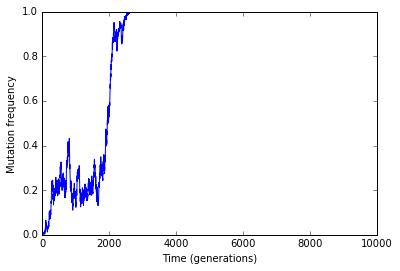

In [6]:
#Frequency trajectories of fixations
fig = plt.figure()
ax = plt.subplot(111)
plt.xlabel("Time (generations)")
plt.ylabel("Mutation frequency")
ax.set_xlim(traj['generation'].min(),traj['generation'].max())
for i in mpos:
    plt.plot(traj[traj['pos']==i]['generation'],traj[traj['pos']==i]['freq'])

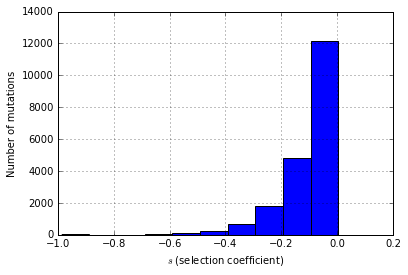

In [7]:
#Let's get histogram of effect sizes for all mutations that did not fix
fig = plt.figure()
ax = plt.subplot(111)
plt.xlabel(r'$s$ (selection coefficient)')
plt.ylabel("Number of mutations")
mfreq[mfreq['freq']<1.0]['esize'].hist()